## Use kernel from 12.30_extendAtlas.ipynb to perform trajDiff

In [483]:
# Using scarches kernel
import sys
sys.path.append("../../function/")
import trajDiff_v129
milo2=trajDiff_v129.Milo2()
import scanpy as sc
import numpy as np
import pandas as pd
import PyComplexHeatmap
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.cluster import KMeans

In [416]:
mes_bool=extendAtlas.obs["lineage_mesenchyme"]=="True"

In [418]:
mesAtlas=extendAtlas[mes_bool]

In [419]:
mesAtlas

View of AnnData object with n_obs × n_vars = 147808 × 20664
    obs: 'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'transf_ann_level_7_label', 'transf_ann_level_6_label', 'transf_ann_level_5_label', 'transf_ann_level_4_label', 'transf_an

In [423]:
set(mesAtlas.obs["Stage"])

{'Development',
 'Disease',
 'Heterotopic ossification ',
 'Injury(5-FU)',
 'Injury(Non-Regeneration)',
 'Injury(Radiation)',
 'Injury(Regeneration)',
 'Steady',
 'Treated',
 'in vitro'}

In [424]:
new_labels = np.where(np.isin(mesAtlas.obs["Stage"], ['Injury(5-FU)', 'Injury(Non-Regeneration)', 'Injury(Radiation)', 'Injury(Regeneration)']),
                      'Injury', 'Other')

In [426]:
np.unique(new_labels, return_counts=True)

(array(['Injury', 'Other'], dtype='<U6'), array([ 33838, 113970]))

In [435]:
np.array(new_labels)

array(['Other', 'Other', 'Other', ..., 'Other', 'Other', 'Other'],
      dtype='<U6')

In [433]:
mesAtlas.obs["Stage"]

Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0_1_1    Development
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0_1_1    Development
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0_1_1    Development
Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0_1_1    Development
Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0_1_1    Development
                                                       ...     
TTTCCTCGTGAAGCGT-1_8                                Development
TTTCGATTCGCTGACG-1_8                                Development
TTTCGATTCTCATTGT-1_8                                Development
TTTCGATTCTCCCATG-1_8                                Development
TTTGTTGAGGAATGTT-1_8                                Development
Name: Stage, Length: 147808, dtype: category
Categories (10, object): ['Development', 'Disease', 'Heterotopic ossification ', 'Injury(5-FU)', ..., 'Injury(Regeneration)', 'Steady', 'Treated', 'in vitro']

In [436]:
mesAtlas.obs["InjuryState"]=new_labels

/tmp/ipykernel_1921307/664343754.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mesAtlas.obs["InjuryState"]=new_labels
/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/contextlib.py:124: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [440]:
mdata = milo2.load(mesAtlas)

In [443]:
sc.pp.neighbors(mdata['rna'], use_rep='scANVI', n_neighbors=300, n_pcs=15)

In [444]:
milo2.make_nhoods(mdata['rna'], prop=0.015)


NameError: name 'adata' is not defined

In [445]:
mdata = milo2.count_nhoods(mdata, sample_col="Sample")


/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [453]:
pseudobulk

AnnData object with n_obs × n_vars = 47407 × 20664
    obs: 'Sample', 'Stage', 'dpt_pred', 'Tissue', 'Tissue(Specific)', 'nhoods_index'
    uns: 'sample_col', 'group_col', 'time_col'

In [447]:
pseudobulk=milo2.make_pseudobulk_parallel(mdata=mdata,sample_col="Sample",group_col="InjuryState",time_col="dpt_pred",other_col=['Tissue', 'Tissue(Specific)'],njob=25,min_cell=4)


100%|██████████| 2023/2023 [30:25<00:00,  1.11it/s]


In [454]:
new_labels = np.where(np.isin(pseudobulk.obs["Stage"], ['Injury(5-FU)', 'Injury(Non-Regeneration)', 'Injury(Radiation)', 'Injury(Regeneration)']),
                      'Injury', 'Other')

In [457]:
pseudobulk.obs["InjuryState"]=new_labels

In [474]:
pseudobulk.write_h5ad("../process_data/traj_diff/1.6_trajdiff_pseudobulk_3.h5ad")

In [475]:
milo_mes=mdata["milo"]

In [478]:
milo_mes.varm["InjuryStateInjury"]

,0610005C13Rik,0610007N19Rik,0610007P14Rik,0610009B22Rik,0610009D07Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,...,Nscme3l,Styx-ps,Ccdc121rt2,Tgoln2,Arih2os,Qki,Gm31160,Tesl2,Nlgn4l,Ahsp
index_cell,,,,,,,,,,,,,,,,,,,,,
Suture2021_Farmer_E17_CCGTGGATCGTCGTTC-1_1-0_1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Suture2021_Farmer_E17_GTGTTAGTCACATACG-1_1-0_1_1,NaN,NaN,0.0,45.342780,NaN,NaN,0.0,4.119908,66.957632,31.808436,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN
Suture2021_Farmer_E17_AACTTTCTCACCGTAA-2_1-0_1_1,0.0,NaN,0.0,61.889242,NaN,NaN,0.0,21.143719,29.384168,32.349598,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
Suture2021_Farmer_E17_ACCAGTAAGGAGTTTA-2_1-0_1_1,NaN,NaN,0.0,62.655825,NaN,NaN,0.0,0.000000,0.000000,90.805404,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
Suture2021_Farmer_E17_ATCATGGTCGCCATAA-2_1-0_1_1,0.0,NaN,0.0,22.777126,NaN,NaN,0.0,43.394601,63.414338,69.941523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACGGGTCGTGCATCTA-1_8,0.0,NaN,0.0,37.803934,NaN,NaN,0.0,55.659395,39.704048,41.176800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAAGCTACACGGCACT-1_8,NaN,NaN,0.0,83.142733,NaN,NaN,NaN,0.000000,0.000000,73.787483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGCATAACAGAGCCCT-1_8,NaN,NaN,0.0,102.352356,NaN,NaN,0.0,0.000000,0.000000,54.230030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
milo_mes.write_h5ad("../process_data/traj_diff/1.6_milo_mes_3.h5ad")

RuntimeError: Unable to create attribute (object header message is too large)

Above error raised while writing key 'InjuryStateInjury' of <class 'h5py._hl.group.Group'> to /

In [458]:
pseudobulk.obs["InjuryState"]

Sample
CalvariaP4_Ayturk_sep_Suture2021_Farmer_E17_CCGTGGATCGTCGTTC-1_1-0_1_1                    Other
ChondroOsteo_Long_sep_Suture2021_Farmer_E17_CCGTGGATCGTCGTTC-1_1-0_1_1                    Other
CranioSoxc_Angelozzi_Prx1CreE15.5_sep_Suture2021_Farmer_E17_CCGTGGATCGTCGTTC-1_1-0_1_1    Other
CranioSoxc_Angelozzi_Prx1CreE17.5_sep_Suture2021_Farmer_E17_CCGTGGATCGTCGTTC-1_1-0_1_1    Other
CranioSoxc_Angelozzi_WTE13.5_sep_Suture2021_Farmer_E17_CCGTGGATCGTCGTTC-1_1-0_1_1         Other
                                                                                          ...  
LimbG610C_Gorrell_calvariaWT2_sep_TGTGTGATCATAGCAC-1_8                                    Other
LimbG610C_Gorrell_calvariaWT3_sep_TGTGTGATCATAGCAC-1_8                                    Other
LimbG610C_Gorrell_calvariaWT4_sep_TGTGTGATCATAGCAC-1_8                                    Other
coronal_Holmes_E16_1_sep_TGTGTGATCATAGCAC-1_8                                             Other
coronal_Holmes_E16_2_sep_TGTGTGAT

In [465]:
mdata

MuData object with n_obs × n_vars = 147808 × 20664
  3 modalities
    rna:	147808 x 20664
      obs:	'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'transf_ann_level_7_label', 'transf_ann_level_6_label', 'transf_ann_level_5_label', 'transf_ann_level_4_label', 'transf_ann_level_3_label', 'transf_ann_level_2_label', 'transf_ann_level_1_label', 'most_confident_level', 'most_confident_uncert', 'most_confident_label', 'transf_ann_level_5_uncert', 'transf_ann_level_4_uncert', 'transf_ann_level_3_uncert', 'transf_ann_level_2_uncert', 'transf_ann_level_1_uncert', 'transf_ann_level_7_uncert', 'transf_ann_level_6_uncert', 'osteoIndex', 'Age_num', 'Age_detail_num', 'leiden_clusters_0.5', 'update_level2', 'C7_named', 'leiden_clusters_4', 'lineage_chondro', 'lineage_laFibro', 'lineage_lepr', 'lineage_mesenchyme', 'dpt_pred', 'lineage', 'lineage_str', 'InjuryState', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'features', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'Age_colors', 'hvg', 'log1p', 'transf_ann_level_2_label_colors', 'update_level2_colors', 'C7_named_colors', 'Organ_colors', 'Stage_colors', 'lineage_mesenchyme_colors', 'lineage_laFibro_colors', 'lineage_chondro_colors', 'lineage_lepr_colors', 'transf_ann_level_3_label_colors', 'Project_colors', 'lineage_str_colors', 'neighbors', 'nhood_neighbors_key'
      obsm:	'X_umap', 'scANVI', 'X_umap_split', 'scANVI_split', 'nhoods'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    milo:	302 x 2023
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'
      varm:	'InjuryStateInjury', 'InjuryStateOther'
    pseudobulk:	47407 x 20664
      obs:	'Sample', 'Stage', 'dpt_pred', 'Tissue', 'Tissue(Specific)', 'nhoods_index', 'InjuryState'
      uns:	'sample_col', 'group_col', 'time_col', 'var1', 'var2'
      varm:	'PValue', 'logFC', 'logCPM', 'FDR', 'F', 'InjuryStateInjury', 'InjuryStateOther'

In [459]:
deg=milo2.da_expression(mdata,design="~InjuryState",model_contrasts="InjuryStateInjury-InjuryStateOther",njob=20,fix_libsize=False)

Using edgeR to find DEG......




  0%|          | 0/2023 [00:00<?, ?it/s]


  1%|          | 20/2023 [01:36<2:40:28,  4.81s/it]Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Una

In [467]:
deg=milo2.makeSPFDR(mdata=mdata,njob=-1)
null_test=milo2.makeShuffleDA(mdata,design="~InjuryState",model_contrasts="InjuryStateInjury-InjuryStateOther",njob=30,times=2)


add spatial FDR......

100%|██████████| 20664/20664 [07:35<00:00, 45.36it/s] 


working on 0 times

Using edgeR to find DEG......

  0%|          | 1/2023 [00:04<2:32:49,  4.53s/it]Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/us

Making FDR

add spatial FDR......

100%|██████████| 20664/20664 [06:38<00:00, 51.81it/s] 


working on 1 times

Using edgeR to find DEG......

  0%|          | 0/2023 [00:00<?, ?it/s]Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/usr/lib/R/bi

Making FDR

add spatial FDR......

100%|██████████| 20664/20664 [07:54<00:00, 43.57it/s]
../../function/trajDiff_v129.py:1233: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean = pd.concat(filtered_dfs).groupby(level=0).mean()


In [471]:
mdata

MuData object with n_obs × n_vars = 147808 × 20664
  3 modalities
    rna:	147808 x 20664
      obs:	'Sample', 'Project', 'Core Dataset', 'Limb Atlas', 'Cranial Atlas', 'Organ', 'Tissue', 'Tissue(Specific)', 'Stage', 'Gene type', 'Treatment', 'Age', 'Age(In Detail)', 'Machine', 'Species', 'Isolation approach', 'Digestion', 'Enzymes', 'Cre', 'Bone Forming Methods', 'Data Source', 'Related Assay', 'Cell Count After QC', 'Origin', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'nCount_originalexp', 'nFeature_originalexp', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'batch', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'transf_ann_level_7_label', 'transf_ann_level_6_label', 'transf_ann_level_5_label', 'transf_ann_level_4_label', 'transf_ann_level_3_label', 'transf_ann_level_2_label', 'transf_ann_level_1_label', 'most_confident_level', 'most_confident_uncert', 'most_confident_label', 'transf_ann_level_5_uncert', 'transf_ann_level_4_uncert', 'transf_ann_level_3_uncert', 'transf_ann_level_2_uncert', 'transf_ann_level_1_uncert', 'transf_ann_level_7_uncert', 'transf_ann_level_6_uncert', 'osteoIndex', 'Age_num', 'Age_detail_num', 'leiden_clusters_0.5', 'update_level2', 'C7_named', 'leiden_clusters_4', 'lineage_chondro', 'lineage_laFibro', 'lineage_lepr', 'lineage_mesenchyme', 'dpt_pred', 'lineage', 'lineage_str', 'InjuryState', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'features', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'Age_colors', 'hvg', 'log1p', 'transf_ann_level_2_label_colors', 'update_level2_colors', 'C7_named_colors', 'Organ_colors', 'Stage_colors', 'lineage_mesenchyme_colors', 'lineage_laFibro_colors', 'lineage_chondro_colors', 'lineage_lepr_colors', 'transf_ann_level_3_label_colors', 'Project_colors', 'lineage_str_colors', 'neighbors', 'nhood_neighbors_key'
      obsm:	'X_umap', 'scANVI', 'X_umap_split', 'scANVI_split', 'nhoods'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    milo:	302 x 2023
      var:	'index_cell', 'kth_distance', 'time', 'range_down', 'range_up'
      uns:	'sample_col'
      varm:	'InjuryStateInjury', 'InjuryStateOther', 'Accept', 'logChange', 'null_mean'
    pseudobulk:	47407 x 20664
      obs:	'Sample', 'Stage', 'dpt_pred', 'Tissue', 'Tissue(Specific)', 'nhoods_index', 'InjuryState'
      var:	'overall_gene_p'
      uns:	'sample_col', 'group_col', 'time_col', 'var1', 'var2', 'shuffle_times', 'sum'
      varm:	'PValue', 'logFC', 'logCPM', 'FDR', 'F', 'InjuryStateInjury', 'InjuryStateOther', 'SPFDR', 'null_mean', 'nullPoint', 'truePoint', 'exprPoint', 'group1_cpm', 'group2_cpm', 'gene_p_adj'

In [469]:
milo2.make_range_gene(mdata=mdata,FDR_threshold=0.05,time_col="dpt_pred")
test=milo2.test_whole_gene(mdata)
milo2.permute_point_gene(mdata)
milo2.test_gene_binom(mdata)

In [473]:
np.sum(pseudobulk.var["overall_gene_p"]<0.05)

7954

In [552]:
df_abs = pseudobulk.varm["logFC"].abs()  # 对DataFrame进行绝对值处理

# 计算每一行的最大值
row_max = df_abs.max(axis=1)

In [564]:
np.sum(row_max>8) 

2913

In [581]:
sigGeneBool=np.array(row_max>8) & np.array(pseudobulk.var["overall_gene_p"]<0.01)

In [582]:
sigGene=pseudobulk.var_names[sigGeneBool]

In [589]:
sigGene=sigGene[0:2035]

In [601]:
sigGene

Index(['0610007N19Rik', '0610007P14Rik', '0610010K14Rik', '0610011F06Rik',
       '1110001J03Rik', '1110004F10Rik', '1110008F13Rik', '1110008P14Rik',
       '1110038B12Rik', '1110065P20Rik',
       ...
       'Zfp593', 'Zfp638', 'Zfp706', 'Zfp948', 'Zfpm2', 'Zfr', 'Zic1', 'Zmat2',
       'Zpr1', 'Zranb2'],
      dtype='object', length=2035)

In [479]:
sigGene=pseudobulk.var_names[np.array(pseudobulk.var["overall_gene_p"]<0.05)]

In [ ]:
np.sum(pseudobulk.var_names[np.array(pseudobulk.var["overall_gene_p"]<0.01)])

In [591]:
exprMatrix=pseudobulk.varm["exprPoint"].loc[sigGene]

In [592]:
exprMatrix=exprMatrix.fillna(0)

In [593]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(exprMatrix)
labels = kmeans.labels_
labels=pd.DataFrame(labels)
labels.index=exprMatrix.index

/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ef8748f23a0>
Traceback (most recent call last):
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zhanglab/mambaforge/envs/celloracle/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
   

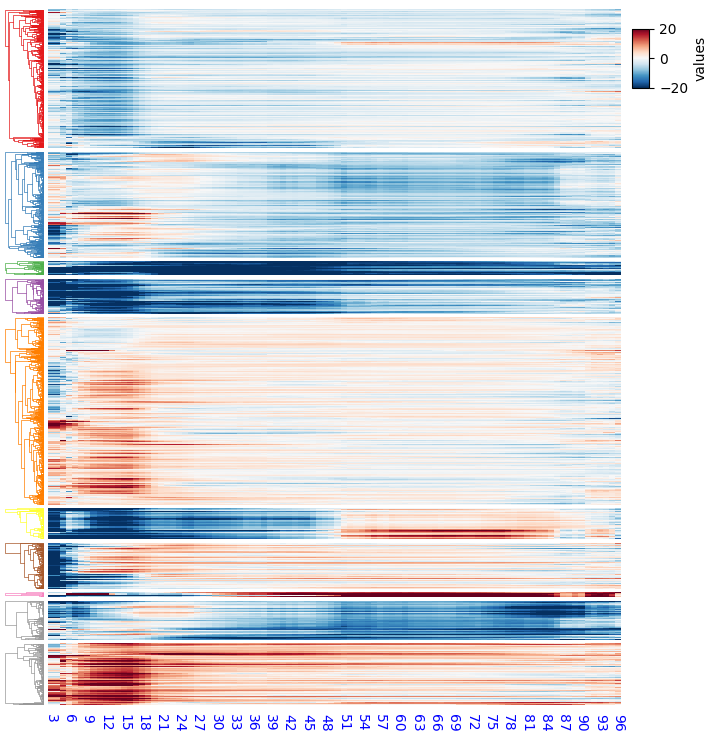

In [594]:
plt.figure(figsize=(8, 8))
cm = PyComplexHeatmap.ClusterMapPlotter(data=exprMatrix,
                       col_cluster=False,row_cluster=True,row_split=labels,
                       row_split_gap=0.8,
                       label='values',row_dendrogram=True,
                       show_rownames=False,show_colnames=True,
                       tree_kws={'row_cmap': 'Set1'},verbose=0,legend_gap=5,
                       cmap='RdBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'},vmax=20,vmin=-20)

In [595]:
exprMatrix.to_csv("../process_data/traj_diff/1.6_exprMatrix.csv")

In [596]:
fdr_matrix=pseudobulk.varm["gene_p_adj"].loc[sigGene]
fdr_matrix=-np.log(fdr_matrix+0.000000001)

In [597]:
cpm1 =  np.log(pseudobulk.varm["group1_cpm"]+1).loc[np.concatenate(cm.row_order),:]
cpm2 =  np.log(pseudobulk.varm["group2_cpm"]+1).loc[np.concatenate(cm.row_order),:]

In [598]:
from sklearn.preprocessing import scale
cpm_bind=pd.concat([cpm1, cpm2], axis=1)
cpm_bind=cpm_bind.fillna(0)
scale_cpm_bind = scale(cpm_bind, axis=1)
scale_cpm_bind=pd.DataFrame(scale_cpm_bind)
scale_cpm_bind.index=cpm_bind.index
scale_cpm_bind.columns=cpm_bind.columns

In [599]:

exprMatrix.loc[np.concatenate(cm.row_order),:].to_csv("../process_data/traj_diff/exprMatrix.csv")
fdr_matrix.loc[np.concatenate(cm.row_order),:].to_csv("../process_data/traj_diff/fdrMatrix.csv")
scale_cpm_bind.to_csv("../process_data/traj_diff/cpmMatrix.csv")

In [603]:
labels.to_csv("../process_data/traj_diff/1.6_label.csv")